<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/321_balance-prior-post.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(prior-influence-notebook)=
# L'influenza della distribuzione a priori

Il dibattito tra approcci bayesiani e frequentisti nella statistica ha avuto un impatto significativo su molteplici discipline, dalla psicologia alla scienza dei dati. Mentre i metodi frequentisti hanno dominato il panorama scientifico per decenni, l'approccio bayesiano sta guadagnando sempre più terreno, grazie alla sua capacità di incorporare conoscenza esperta e credenze preesistenti nel modello statistico. In questo contesto, questo capitolo si focalizza sull'importanza e sulle implicazioni della soggettività intrinseca nella scelta dei priori durante il processo di aggiornamento bayesiano. Esploreremo come questa soggettività possa influenzare le conclusioni derivate da analisi bayesiane e come possa essere mitigata o valorizzata attraverso metodologie rigorose.

Per illustrare questi concetti, esamineremo dettagliatamente alcuni esempi, tra cui un caso studio tratto dal libro "Bayes Rules!" di Johnson e collaboratori {cite:p}`Johnson2022bayesrules`. Questi esempi ci serviranno come veicolo per comprendere come l'integrazione di informazioni a priori e dati osservati avviene in pratica, e come essa possa portare a inferenze più robuste e ben informate.

L'obiettivo del capitolo è quindi fornire una panoramica accessibile delle sfide e delle potenzialità inerenti all'uso dei priori nell'approccio bayesiano, al fine di migliorare la comprensione del suo ruolo crescente nel panorama scientifico attuale.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import requests
import seaborn as sns
import arviz as az
from scipy import integrate, stats
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [ ]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Il caso beta-binomiale

La formula $ p(\theta \mid y) \propto p(\theta) \times p(y \mid \theta) $ è fondamentale per la comprensione dell'inferenza bayesiana. Essa illustra chiaramente che la distribuzione a posteriori emerge dalla congiunzione tra la distribuzione a priori e la funzione di verosimiglianza associata ai dati osservati. Questa sinergia permette di integrare informazioni a priori con evidenze empiriche recenti, risultando in una stima a posteriori del parametro $ \theta $ che è caratterizzata da un elevato grado di precisione e informatività.

Nel corso di questo capitolo, faremo uso di due funzioni specifiche per esplorare il modello beta-binomiale: `plot_beta_binomial` e `summarize_beta_binomial`. La prima funzione permette di visualizzare graficamente le distribuzioni a priori, di verosimiglianza e a posteriori, offrendo quindi un quadro intuitivo dell'aggiornamento bayesiano. La seconda funzione, invece, si concentra sull'estrazione di statistiche descrittive come la media, la moda e la varianza dalla distribuzione a posteriori. Entrambe queste risorse provengono dal testo di {cite:t}`Johnson2022bayesrules` e saranno strumentali per una comprensione approfondita del modello in esame.

In [3]:
def plot_beta_binomial(
    alpha, beta, y=None, n=None, prior=True, likelihood=True, posterior=True
) -> None:
    """Plot a Beta-Binomial Bayesian Model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y observed number of successes
    @param n observed number of trials
    @param prior a logical value indicating whether the prior model should be plotted
    @param likelihood a logical value indicating whether the scaled likelihood should be plotted
    @param posterior a logical value indicating whether posterior model should be plotted
    """

    if y is None or n is None:
        print("Warning: to visualize the posterior specify function parameters y and n")

    θ = np.linspace(0, 1, 100)
    p_theta_given_y = stats.beta.pdf(θ, alpha, beta)
    plt.fill_between(θ, p_theta_given_y, lw=4, color="k", label="prior", alpha=0.2)
    alpha_post = alpha + y
    beta_post = beta + n - y
    p_theta_given_y_post = stats.beta.pdf(θ, alpha_post, beta_post)
    plt.fill_between(θ, p_theta_given_y_post, lw=4, color="r", label="posterior", alpha=0.2)
    likelihood = stats.binom.pmf(y, n, θ)
    scale_factor = integrate.simpson(likelihood, θ)
    plt.fill_between(
        θ, likelihood / scale_factor, lw=4, color="b", label="likelihood scaled", alpha=0.2
    )
    plt.xlabel(r"$\pi$")
    plt.ylabel("density")
    plt.legend()


def summarize_beta_binomial(alpha, beta, y=None, n=None):
    """Summarize a Beta-Binomial Bayesian model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y number of successes
    @param n number of trials

    Return: Pandas dataframe summarizing beta binomial
    """

    def beta_mean(a, b):
        return a / (a + b)

    def beta_mode(a, b):
        if a < 1 and b < 1:
            return "0 and 1"
        elif a <= 1 and b > 1:
            return 0
        elif a > 1 and b < 1:
            return 1
        else:
            return (a - 1) / (a + b - 2)

    def beta_var(a, b):
        return a * b / ((a + b) ** 2 * (a + b + 1))

    prior_mean = beta_mean(alpha, beta)
    prior_mode = beta_mode(alpha, beta)
    prior_var = beta_var(alpha, beta)
    prior_sd = np.sqrt(prior_var)
    if y is None and n is None:
        summary = pd.DataFrame(
            {
                "alpha": alpha,
                "beta": beta,
                "mean": prior_mean,
                "mode": prior_mode,
                "var": prior_var,
                "sd": prior_sd,
            },
            index=["prior"],
        )
    else:
        post_alpha = y + alpha
        post_beta = n - y + beta
        post_mean = beta_mean(post_alpha, post_beta)
        post_mode = beta_mode(post_alpha, post_beta)
        post_var = beta_var(post_alpha, post_beta)
        post_sd = np.sqrt(post_var)
        summary = pd.DataFrame(
            {
                "alpha": [alpha, post_alpha],
                "beta": [beta, post_beta],
                "mean": [prior_mean, post_mean],
                "mode": [prior_mode, post_mode],
                "var": [prior_var, post_var],
                "sd": [prior_sd, post_sd],
            },
            index=["prior", "posterior"],
        )
    return summary

Nel caso in cui disponiamo di un campione di dati di dimensioni molto ridotte, come ad esempio 15 successi su 20 tentativi in una distribuzione beta-binomiale, la distribuzione a priori può esercitare un notevole impatto sulla distribuzione a posteriori. In contrasto, se consideriamo una distribuzione a priori uniforme, la distribuzione a posteriori assomiglierà alla funzione di verosimiglianza, con l'eccezione dell'area sotto le due curve. In parole più semplici, quando la distribuzione a priori è uniforme, la distribuzione a posteriori presenterà un picco nella stima di massima verosimiglianza. Tuttavia, quando adottiamo diverse distribuzioni a priori, la distribuzione a posteriori potrebbe notevolmente discostarsi.

Cominciamo esaminando il caso in cui viene adottata una distribuzione a priori uniforme.

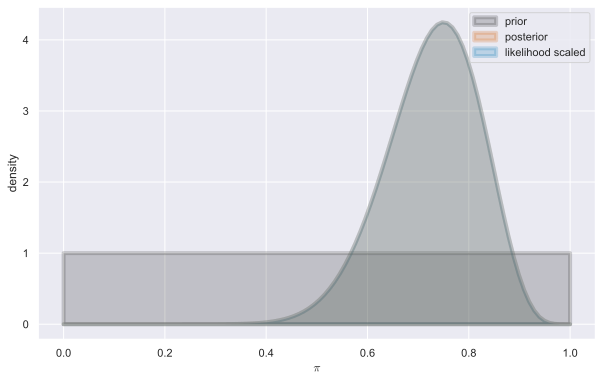

In [4]:
plot_beta_binomial(alpha=1, beta=1, y=15, n=20)

Esaminiamo ora l'effetto di una distribuzione a priori poco informativa, come ad esempio una Beta(2, 2). In questa situazione, l'impatto di tale scelta sulla distribuzione a posteriori è di modesta entità, ma comunque presente. Questo fenomeno può essere interpretato come un effetto di "regolarizzazione", il quale influisce sulla nostra stima in modo più cauto rispetto a quanto ottenuto tramite il principio di massima verosimiglianza. In altre parole, la stima risultante risulta essere più "bilanciata" verso il valore intermedio di 0.5.

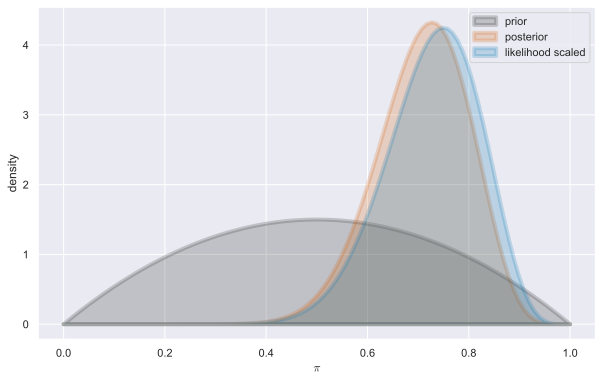

In [5]:
plot_beta_binomial(alpha=2, beta=2, y=15, n=20)

In [6]:
summarize_beta_binomial(alpha=2, beta=2, y=15, n=20)

,alpha,beta,mean,mode,var,sd
prior,2,2,0.500000,0.500000,0.050000,0.223607
posterior,17,7,0.708333,0.727273,0.008264,0.090906


Se il campione è di dimensioni maggiori, l'adozione di una distribuzione a priori Beta(2, 2) ha un effetto trascurabile: infatti, il valore massimo della distribuzione a posteriori risulta essere quasi identico alla stima di massima verosimiglianza.

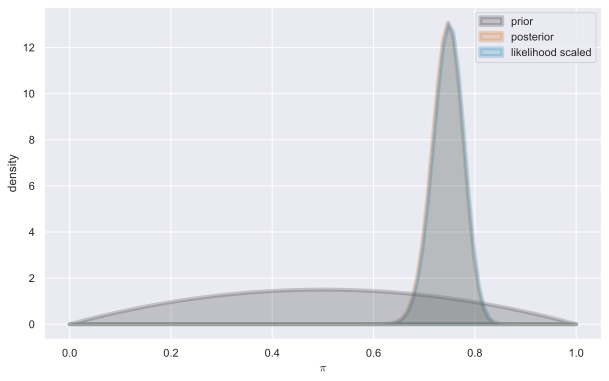

In [7]:
plot_beta_binomial(alpha=2, beta=2, y=150, n=200)

In [8]:
summarize_beta_binomial(alpha=2, beta=2, y=150, n=200)

,alpha,beta,mean,mode,var,sd
prior,2,2,0.500000,0.500000,0.050000,0.223607
posterior,152,52,0.745098,0.747525,0.000926,0.030438


Se optiamo per una distribuzione a priori informativa, questa avrà un notevole impatto sulla distribuzione a posteriori quando ci si trova di fronte a un campione di dimensioni ridotte.

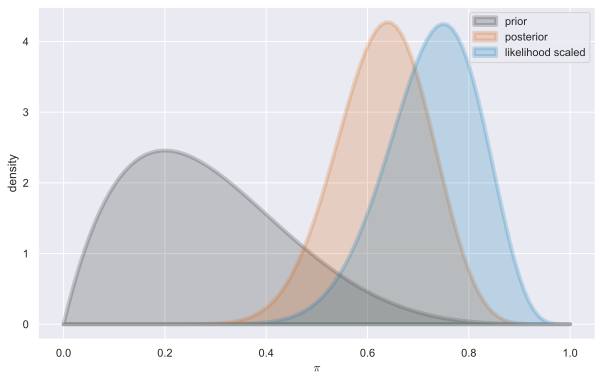

In [9]:
plot_beta_binomial(alpha=2, beta=5, y=15, n=20)

In [12]:
summarize_beta_binomial(alpha=2, beta=5, y=15, n=20)

,alpha,beta,mean,mode,var,sd
prior,2,5,0.285714,0.20,0.025510,0.159719
posterior,17,10,0.629630,0.64,0.008328,0.091260


Al contrario, la medesima distribuzione a priori ha un effetto insignificante sulla distribuzione a posteriori quando il campione è di dimensioni considerevoli.

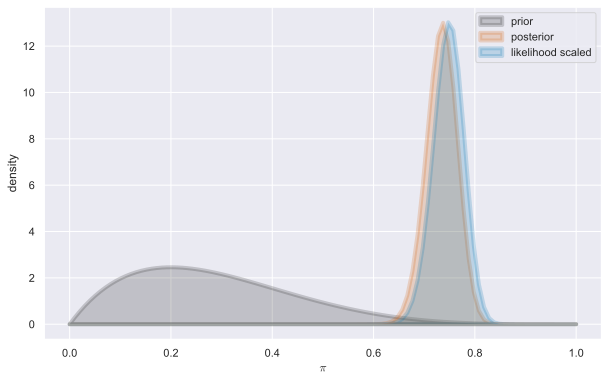

In [10]:
plot_beta_binomial(alpha=2, beta=5, y=150, n=200)

In [13]:
summarize_beta_binomial(alpha=2, beta=5, y=150, n=200)

,alpha,beta,mean,mode,var,sd
prior,2,5,0.285714,0.200000,0.025510,0.159719
posterior,152,55,0.734300,0.736585,0.000938,0.030627


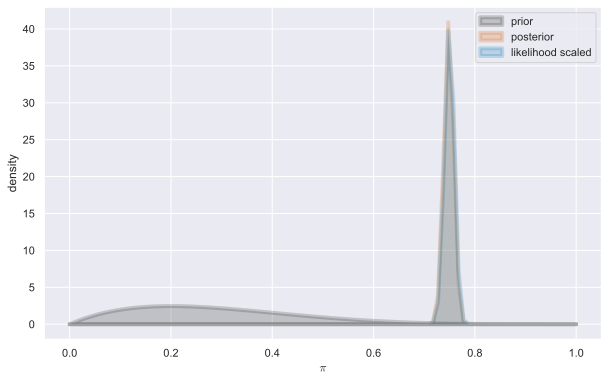

In [11]:
plot_beta_binomial(alpha=2, beta=5, y=1500, n=2000)

In [15]:
summarize_beta_binomial(alpha=2, beta=5, y=1500, n=2000)

,alpha,beta,mean,mode,var,sd
prior,2,5,0.285714,0.200000,0.025510,0.159719
posterior,1502,505,0.748381,0.748628,0.000094,0.009684


## Connessione tra intuizioni e teoria

L'equilibrio tra la distribuzione a priori e le evidenze provenienti dai dati, come dimostrato negli esempi precedenti, non solo rispecchia le nostre intuizioni, ma rappresenta anche una necessità matematica. Questo concetto diventa chiaro esaminando la formula del valore atteso della distribuzione a posteriori nel contesto del caso beta-binomiale, che può essere riscritta come segue:

$$
\begin{align}
\mathbb{E}_{\text{post}} &[\text{Beta}(\alpha + y, \beta + n - y)] = \frac{\alpha + y}{\alpha + \beta + n} \\
&= \frac{a+b}{a+b+n} \cdot \frac{a}{a+b} + \frac{n}{a+b+n} \cdot \frac{y}{n}.
\end{align}
$$ 

L'equazione precedente rivela che il valore atteso a posteriori si ottiene come una media ponderata tra il valore atteso a priori $\left( \frac{\alpha}{\alpha+\beta}\right)$ e la proporzione osservata dei successi $\left(\frac{y}{n}\right)$. I pesi sono dati da $\left( \frac{\alpha+\beta}{\alpha+\beta+n}\right)$ e $\left( \frac{n}{\alpha+\beta+n}\right)$. Pertanto, quando il numero di osservazioni $n$ è significativo rispetto alla somma dei parametri $\alpha + \beta$, la distribuzione a posteriori sarà principalmente influenzata dai dati osservati e in minor misura dalle credenze a priori. Al contrario, se $n$ è piccolo rispetto a $\alpha + \beta$, i dati avranno un peso inferiore rispetto alle credenze a priori.

Queste considerazioni indicano come scegliere i parametri $\alpha$ e $\beta$: se desideriamo rappresentare una totale ignoranza sul fenomeno, una scelta coerente è $\alpha = \beta = 1$ (attribuiamo uguale credibilità a ogni valore di $\theta$). Se, invece, possediamo forti credenze a priori, possiamo selezionare $\alpha$ in modo da eguagliare il valore atteso a priori, mentre $\alpha + \beta$ rifletterà l'importanza attribuita all'informazione a priori: maggiore è il valore di $\alpha + \beta$, maggiore sarà il numero di dati necessari per influenzare significativamente la distribuzione a posteriori rispetto a quella a priori. In situazioni in cui $n$ è considerevolmente grande, la distribuzione a posteriori avrà un impatto ridotto sulla distribuzione a priori, a meno che non si facciano scelte estreme per i parametri a priori.

## Commenti e considerazioni finali 

La conclusione dell'esempio presentato da [Johnson (2022)](https://link.springer.com/chapter/10.1007/978-3-030-85974-1_6) ci offre una panoramica intuitiva ma fondamentale: l'aggiornamento bayesiano rispecchia i processi di ragionamento che intuitivamente utilizziamo nel quotidiano. Quando ci troviamo di fronte a nuove evidenze deboli, le nostre credenze preesistenti rimangono invariate. Al contrario, evidenze robuste ci costringono a rivedere e aggiornare le nostre credenze in linea con i nuovi dati. Questa è la quintessenza dell'approccio bayesiano: un meccanismo quantitativo e preciso che formalizza le nostre intuizioni.

Questo è in netto contrasto con l'approccio frequentista, che ignora le credenze o le conoscenze preesistenti. In questo schema, i risultati di un test statistico basato su un campione limitato di dati possono portare a una modifica delle credenze senza alcuna considerazione per le evidenze o le intuizioni pregresse. Questo divario metodologico tra i due approcci è sintetizzata con efficacia nella celebre striscia comica di [xkcd](https://xkcd.com/1132/).

Entrando nel dettaglio del contesto bayesiano, la scelta delle distribuzioni a priori è un elemento cruciale, con due obiettivi principali. In primo luogo, l'utilizzo di distribuzioni a priori debolmente informative agisce come un meccanismo di regolarizzazione, contribuendo a ottenere inferenze più prudenti mitigando l'effetto di osservazioni estreme. Questo aspetto è generalmente accettato e ritenuto non controverso nel campo statistico.

In secondo luogo, un settore in rapida crescita e di grande interesse è l'integrazione esplicita di conoscenza esperta preesistente. Tale processo, noto come 'elicitazione della conoscenza esperta' (*expert knowledge elicitation*) {cite:p}`brownstein2019role`, va ben oltre la semplice intervista con gli esperti. Esso richiede un elevato grado di rigore metodologico per prevenire l'insorgenza di bias cognitivi. Questo aspetto è particolarmente rilevante in ambiti come la psicologia, dove gli sviluppi teorici possono essere meno frequenti. Tale necessità è supportata da un'ampia letteratura accademica e da protocolli ben definiti, quali Cooke, SHELF e Delphi probabilistico {cite:p}`o2019expert`.

In conclusione, pur aspirando all'obiettività come ideale della ricerca scientifica, è indispensabile riconoscere e affrontare la soggettività intrinseca nel processo di scelta dei priori. Attraverso l'uso di protocolli rigorosi di elicitazione della conoscenza esperta, è possibile realizzare analisi bayesiane robuste e ben informate, che riflettano in modo accurato sia le incertezze intrinseche che la competenza specifica nel campo di studio.


## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w